<a href="https://colab.research.google.com/github/aboelela924/dcgan_mnist/blob/master/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [238]:
import tensorflow as tf 
from tensorflow import keras 
import tensorflow_datasets as tfds
from tensorflow import nn
import numpy as np 
import matplotlib.pyplot as plt 

In [239]:
ds_train, info = tfds.load("mnist", split="train", as_supervised=True, 
                                      with_info=True)
ds_test, info = tfds.load("mnist", split="test", as_supervised=True, 
                                      with_info=True)

In [240]:
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5
    return image, label

In [241]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [242]:
ds_train = ds_train.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(BUFFER_SIZE)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [243]:
ds_test = ds_test.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [244]:
def loss_real(label):
    criterion = tf.losses.BinaryCrossentropy(from_logits=True)
    return criterion(tf.ones_like(label), label)

In [245]:
def loss_fake(label):
    criterion = tf.losses.BinaryCrossentropy(from_logits=True)
    return criterion(tf.zeros_like(label), label)

In [246]:
g_optimizer = tf.keras.optimizers.Adam(1e-4)
d_optimizer = tf.keras.optimizers.Adam(1e-4)

In [247]:
discriminator = keras.Sequential([
                                  
            keras.layers.Conv2D(64, 5, 2,padding="same", input_shape=(28,28, 1)),
            keras.layers.LeakyReLU(),
            keras.layers.Dropout(0.3),

            keras.layers.Conv2D(128, 5, 2,padding="same"),
            keras.layers.LeakyReLU(),
            keras.layers.Dropout(0.3),

            # keras.layers.MaxPooling2D(pool_size=4),
            keras.layers.Flatten(),
            # keras.layers.Conv2D(64, 3, 2,padding="same"),
            # keras.layers.LeakyReLU(alpha=0.2),
            # keras.layers.Dropout(0.2),
            # keras.layers.Conv2D(64, 3, 2,padding="same"),
            # keras.layers.LeakyReLU(alpha=0.2),
            # keras.layers.Dropout(0.2),
            # keras.layers.Conv2D(64, 3, 2,padding="same"),
            # keras.layers.LeakyReLU(alpha=0.2),
            # keras.layers.Flatten(),
            keras.layers.Dense(1)
])
discriminator.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_76 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_77 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 6272)            

In [248]:
noise_vector_length = 128


generator = keras.Sequential([           
    keras.layers.Dense(7*7*256, input_shape=(noise_vector_length, ), use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),

    keras.layers.Reshape((7,7,256)),                          
    
    keras.layers.Conv2DTranspose(128, 5, 1, padding="same", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    
    keras.layers.Conv2DTranspose(64, 5, 2, padding="same",use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),

    keras.layers.Conv2DTranspose(1, 5, 2, padding="same", activation="tanh", use_bias=False)
])

generator.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 12544)             1605632   
_________________________________________________________________
batch_normalization_37 (Batc (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_78 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_12 (Reshape)         (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_38 (Conv2DT (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_38 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_79 (LeakyReLU)   (None, 7, 7, 128)       

In [250]:
@tf.function
def train_step(images):
    noise_vector = tf.random.normal((BATCH_SIZE, noise_vector_length))
    
    
    real_images = images

    with tf.GradientTape() as d_tape:
        d_fake_images = generator(noise_vector)

        d_out_real = discriminator(real_images, training=True)
        d_out_fake = discriminator(d_fake_images, training=True)

        d_loss = loss_real(d_out_real) + loss_fake(d_out_fake)
    
    noise_vector = tf.random.normal((BATCH_SIZE, noise_vector_length))
    with tf.GradientTape() as g_tape:
        g_fake_images = generator(noise_vector, training=True)
        g_out = discriminator(g_fake_images)
        g_loss = loss_real(g_out)


    d_grads = d_tape.gradient(d_loss, discriminator.trainable_weights)
    d_optimizer.apply_gradients(zip(d_grads, discriminator.trainable_weights))

    g_grads = g_tape.gradient(g_loss, generator.trainable_weights)
    g_optimizer.apply_gradients(zip(g_grads, generator.trainable_weights))
     
    
    return d_loss, g_loss


In [251]:
@tf.function
def validation_step(images):
    noise_vector = tf.random.normal((BATCH_SIZE, noise_vector_length))
    g_fake_images = generator(noise_vector)
    g_out = discriminator(g_fake_images)
    print(g_out)
    g_loss = loss_real(g_out)
    return g_loss

In [252]:
import os

path = "/content/training_checkpoints"
if not os.path.isdir(path):
    os.mkdir(path)

checkpoint_dir = '/content/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=g_optimizer,
                                 discriminator_optimizer=d_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [266]:
EPOCHS = 100

def train(dataset, val_dataset,epochs=10):

    for e in range(epochs):
        i = 0
        print(f"Epoch: {e+1}")
        for batch, labels in dataset:
            i+=1
            d_loss, g_loss = train_step(batch)
            if (i % 100 == 0):
                print(f"Discriminator loss: {d_loss.numpy()}, Generator loss: {g_loss.numpy()}")


        if (e + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        # for batch, labels in val_dataset:
        #     i+=1
        #     g_loss = validation_step(batch)
        #     if (i % 100 == 0):
        #         print(f"Generator validation loss: {g_loss.numpy()}")

train(ds_train, ds_test, EPOCHS)


Epoch: 1
Discriminator loss: 1.31233549118042, Generator loss: 0.7794954180717468
Discriminator loss: 1.2516810894012451, Generator loss: 0.8915071487426758
Epoch: 2
Discriminator loss: 1.223323106765747, Generator loss: 0.7697426676750183
Discriminator loss: 1.227557897567749, Generator loss: 0.8312348127365112
Epoch: 3
Discriminator loss: 1.2388931512832642, Generator loss: 0.9343019723892212
Discriminator loss: 1.2251348495483398, Generator loss: 0.9681192636489868
Epoch: 4
Discriminator loss: 1.3070257902145386, Generator loss: 0.7253121137619019
Discriminator loss: 1.2952141761779785, Generator loss: 0.8586172461509705
Epoch: 5
Discriminator loss: 1.3817870616912842, Generator loss: 0.7736858129501343
Discriminator loss: 1.3087449073791504, Generator loss: 0.8806925415992737
Epoch: 6
Discriminator loss: 1.2910481691360474, Generator loss: 0.8744495511054993
Discriminator loss: 1.2500603199005127, Generator loss: 0.7885403037071228
Epoch: 7
Discriminator loss: 1.2520015239715576, G

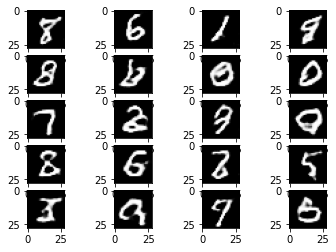

In [267]:
fig, axs = plt.subplots(5,4)
for i in range(5):
    for j in range(4):
        noise = tf.random.normal([1, noise_vector_length])
        generated_image = generator(noise, training=False)
        axs[i,j].imshow(generated_image[0, :, :, 0], cmap='gray')